[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ic22YVZF74IiQy6cRDj-LwaOoM4BapVl?usp=sharing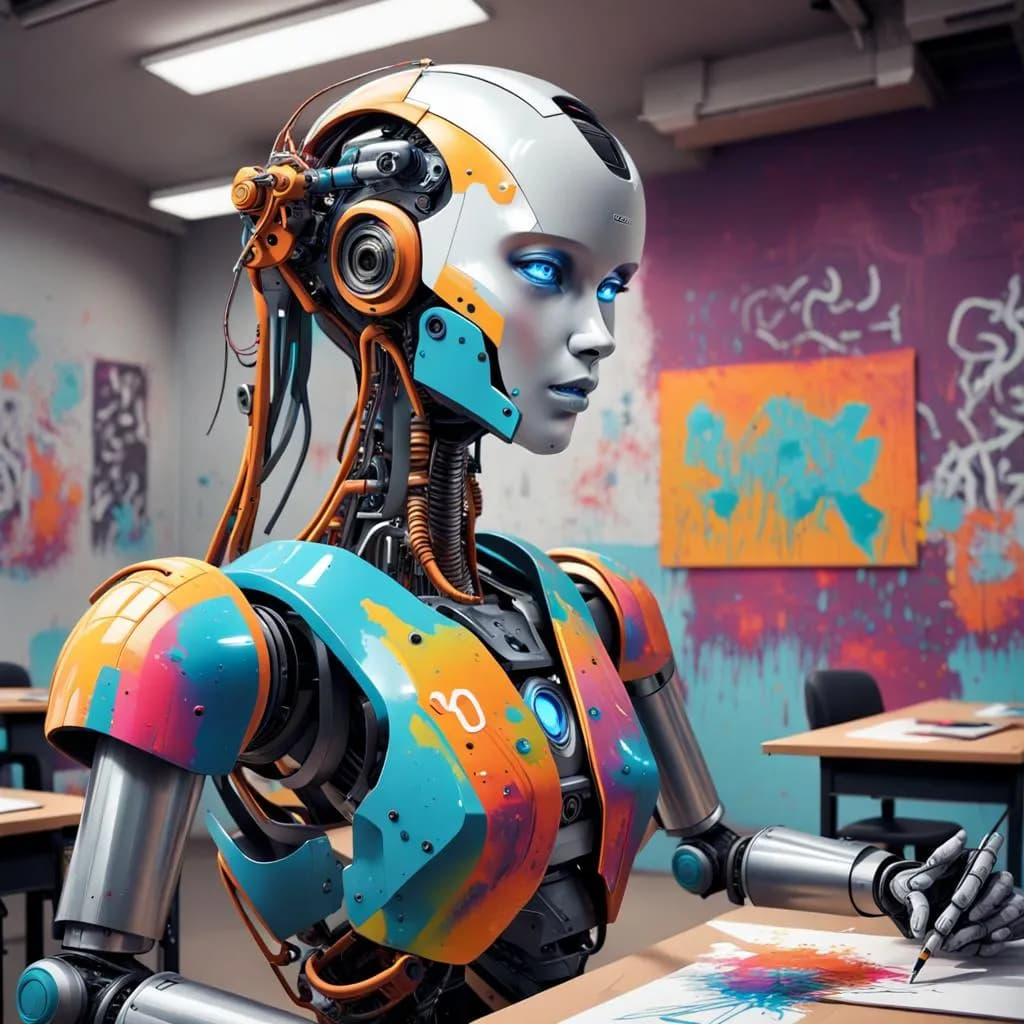)



# Fine-Tuning RoBERTa for Sentiment Analysis with PEFT on IMDB Dataset







## Summary
* PEFT technique: LORA
* Model: FacebookAI/roberta-base
* Evaluation approach: Accuracy
* Fine-tuning dataset: stanfordnlp/imdb

## Intro
This model is a fine-tuned version of the bert-base model to classify the sentiment of movie reviews into one of two categories: negative(label 0), positive(label 1).






## Install dependencies




In [6]:
!pip install datasets
!pip install transformers datasets evaluate accelerate peft
!pip install scikit-learn

## Dataset Preprocessing


# New Section
**Load a pretrained HF model and load and preprocess a dataset**

In [ ]:
import torch
from transformers import RobertaModel, RobertaTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from peft import LoraConfig, get_peft_model
from datasets import load_dataset

# Load a pretrained model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(base_model, num_labels=num_labels)

# Define base model name
base_model = 'roberta-base'

# Load the IMDB dataset
dataset = load_dataset("stanfordnlp/imdb")

# Load the tokenizer for the base model
tokenizer = RobertaTokenizer.from_pretrained(base_model)

# Define a function to preprocess the data
def preprocess(examples):
    # Tokenize the input text with truncation and padding
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

# Apply preprocessing to the entire dataset and remove the original text column
tokenized_dataset = dataset.map(preprocess, batched=True, remove_columns=["text"])

# Select a subset of the train, unsupervised, and test datasets for training, evaluation, and testing
train_dataset = tokenized_dataset['train'].select(range(900))
test_dataset = tokenized_dataset['unsupervised'].select(range(100))
eval_dataset = tokenized_dataset['test'].select(range(100))

# Extract the number of classes and their names
num_labels = dataset['train'].features['label'].num_classes
class_names = dataset["train"].features["label"].names

# Print the number of labels and their names
print(f"Number of labels: {num_labels}")
print(f"The labels: {class_names}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

number of labels: 2
the labels: ['neg', 'pos']


In [ ]:
# Create an id2label mapping for our classifier.
# This dictionary maps numerical class indices to human-readable labels.
id2label = {i: label for i, label in enumerate(class_names)}

# Initialize a data collator with padding for the tokenizer.
# The data collator is responsible for padding the inputs to the same length,
# which is necessary for batch processing. It also handles the conversion
# of input data to PyTorch tensors.
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


**Evaluate the pretrained model**

In [ ]:
from transformers import TrainingArguments

# Define a metric for evaluation and set up the Trainer to include this evaluation step
# Function to compute metrics
def compute_metrics(pred):
    logits, labels = pred
    predictions = logits.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Define the training arguments for the Trainer
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='steps',
    learning_rate=2e-5,
    num_train_epochs=1,
    per_device_train_batch_size=8,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import RobertaForSequenceClassification

# Load the Roberta model for sequence classification with the specified number of labels
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)

# Creates and returns a Trainer instance for training and evaluating the model
def get_trainer(model):
      return  Trainer(
          model=model,
          args=training_args,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
          compute_metrics=compute_metrics,
      )

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import AutoModelForSequenceClassification

# Create a full fine-tuning trainer
full_finetuning_trainer = get_trainer(
    # Load the pre-trained model for sequence classification
    AutoModelForSequenceClassification.from_pretrained(base_model, id2label=id2label),
)

# Start training the model using the trainer
full_finetuning_trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


TrainOutput(global_step=113, training_loss=0.04381228759225491, metrics={'train_runtime': 101.0691, 'train_samples_per_second': 8.905, 'train_steps_per_second': 1.118, 'total_flos': 236799949824000.0, 'train_loss': 0.04381228759225491, 'epoch': 1.0})

## Training

Let's Train two models, one using LORA and the other with full fine-tuning.

Note the LORA training times and the number of trained parameters!

### PEFT Training

**Create a PEFT model and train the PEFT model**

In [ ]:
from transformers import AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model

# Load the pre-trained model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(base_model, id2label=id2label)

# Define the configuration for LoRA (Low-Rank Adaptation)
peft_config = LoraConfig(
    task_type="SEQ_CLS",         # Specify the task type as sequence classification
    inference_mode=False,        # Set to False to enable training mode; True would enable inference mode
    r=8,                         # Rank of the low-rank adaptation; controls the number of parameters
    lora_alpha=16,               # Scaling factor for LoRA; helps to adjust the importance of LoRA parameters
    lora_dropout=0.1             # Dropout rate for LoRA parameters to prevent overfitting
)

# Apply LoRA to the pre-trained model
peft_model = get_peft_model(model, peft_config)

# Print the trainable parameters of the PEFT model
print('PEFT Model')
peft_model.print_trainable_parameters()

# Create a trainer instance for fine-tuning the PEFT model
peft_lora_finetuning_trainer = get_trainer(peft_model)

# Start the training process for the PEFT model using the trainer
peft_lora_finetuning_trainer.train()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT Model
trainable params: 887,042 || all params: 125,534,212 || trainable%: 0.7066


Step,Training Loss,Validation Loss


TrainOutput(global_step=113, training_loss=0.3685365187383331, metrics={'train_runtime': 69.7895, 'train_samples_per_second': 12.896, 'train_steps_per_second': 1.619, 'total_flos': 239252443545600.0, 'train_loss': 0.3685365187383331, 'epoch': 1.0})

In [ ]:
**Save the PEFT model**

In [ ]:
# The notebook was run in Google Colab because the Udacity Workspace environment's kernel kept crashing,
# even with a reduced dataset, causing extended training times for a small model.

# Mount Google Drive to access it within Colab
from google.colab import drive
drive.mount('/content/drive')

import os

# Define the path in Google Drive for saving the tokenizer
save_directory = '/content/drive/My Drive/roberta-base-modified'

# Create the directory if it does not already exist
os.makedirs(save_directory, exist_ok=True)

# Save the tokenizer to the specified directory
tokenizer.save_pretrained(save_directory)

# Define the path in Google Drive for saving the fine-tuned model
save_directory = '/content/drive/My Drive/roberta-base-peft'

# Create the directory if it does not already exist
os.makedirs(save_directory, exist_ok=True)

# Save the fine-tuned model to the specified directory
peft_model.save_pretrained(save_directory)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Performing Inference with a PEFT Model

It's time to have some fun putting our model to work!

In [ ]:
from peft import AutoPeftModelForSequenceClassification
from transformers import AutoTokenizer

# Load the saved PEFT model from the specified directory
inference_model = AutoPeftModelForSequenceClassification.from_pretrained(peft_model_name, id2label=id2label)

# Load the tokenizer used for preprocessing the input text
tokenizer = AutoTokenizer.from_pretrained(modified_base)

def classify(text):
    # Tokenize the input text, handling truncation and padding, and prepare it for the model
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt")

    # Perform inference with the loaded PEFT model
    output = inference_model(**inputs)

    # Get the predicted class by finding the index of the maximum logit value
    prediction = output.logits.argmax(dim=-1).item()

    # Print the predicted class, corresponding label, and the input text
    print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
classify( "I would put this at the top of my list of films in the category of unwatchable trash! There are films that are bad, but the worst kind are the ones that are unwatchable but you are suppose to like them because they are supposed to be good for you! ")
classify( "Its not the cast. A finer group of actors, you could not find. Its not the setting. The director is in love with New York City, and by the end of the film, so are we all! Woody Allen could not improve upon what Bogdonovich has done here. If you are going to fall in love, or find love, Manhattan is the place to go. No, the problem with the movie is the script. ")


 Class: 0, Label: neg, Text: I would put this at the top of my list of films in the category of unwatchable trash! There are films that are bad, but the worst kind are the ones that are unwatchable but you are suppose to like them because they are supposed to be good for you! 

 Class: 0, Label: neg, Text: Its not the cast. A finer group of actors, you could not find. Its not the setting. The director is in love with New York City, and by the end of the film, so are we all! Woody Allen could not improve upon what Bogdonovich has done here. If you are going to fall in love, or find love, Manhattan is the place to go. No, the problem with the movie is the script. 


### Evaluate Models
  



In [ ]:
**Load the saved PEFT model**

In [ ]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

# Load the accuracy metric for evaluation
metric = evaluate.load('accuracy')

def evaluate_model(inference_model, dataset):
    # Create a DataLoader for the evaluation dataset
    eval_dataloader = DataLoader(
        dataset.rename_column("label", "labels"),  # Rename 'label' column to 'labels' for consistency
        batch_size=8,  # Batch size for evaluation
        collate_fn=data_collator  # Function to collate data samples into batches
    )

    # Determine the device to use (GPU if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move the model to the appropriate device
    inference_model.to(device)

    # Set the model to evaluation mode
    inference_model.eval()

    # Iterate over the evaluation dataset
    for step, batch in enumerate(tqdm(eval_dataloader)):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():  # Disable gradient calculation for evaluation
            outputs = inference_model(**batch)

        # Get predictions from the model output
        predictions = outputs.logits.argmax(dim=-1)

        # Get references (true labels) from the batch
        references = batch["labels"]

        # Add predictions and references to the metric for evaluation
        metric.add_batch(
            predictions=predictions,
            references=references,
        )

    # Compute the final evaluation metric
    eval_metric = metric.compute()

    print(eval_metric)


**Evaluate the fine-tuned model**

In [ ]:
# Evaluate the non fine-tuned model
evaluate_model(AutoModelForSequenceClassification.from_pretrained(base_model, id2label=id2label), test_dataset)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 475/475 [00:13<00:00, 35.48it/s]

{'accuracy': 0.24868421052631579}


In [ ]:
# Evaluate the PEFT fine-tuned model
evaluate_model(inference_model, test_dataset)

100%|██████████| 475/475 [00:13<00:00, 34.20it/s]

{'accuracy': 0.9278947368421052}


In [ ]:
# Evaluate the Fully fine-tuned model
evaluate_model(full_finetuning_trainer.model, test_dataset)

100%|██████████| 475/475 [00:13<00:00, 35.56it/s]

{'accuracy': 0.9460526315789474}
